# `Company Bankruptcy Prediction`

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from random import randint
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel, mutual_info_classif, f_classif, SelectKBest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, \
  f1_score,accuracy_score, precision_score, recall_score, roc_auc_score 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import warnings
warnings.filterwarnings("ignore")

## Data import and Cleaning

In [2]:
ds = pd.read_csv('Company Bankruptcy Prediction.csv')
ds.shape

(6819, 96)

In [3]:
ds.columns = [i.title().strip() for i in list(ds.columns)]

In [4]:
#checking for null values
ds.isnull().sum().sort_values(ascending=False).head(1)

Bankrupt?    0
dtype: int64

## Data Visualization

In [5]:
ds['Bankrupt?'].value_counts()


0    6599
1     220
Name: Bankrupt?, dtype: int64

<AxesSubplot:xlabel='Bankrupt?', ylabel='count'>

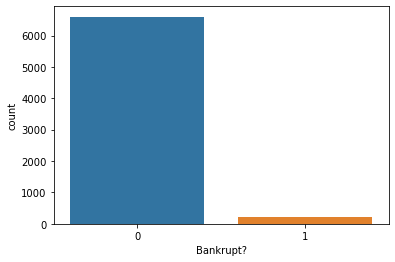

In [6]:
sns.countplot('Bankrupt?',data=ds)

#### The records are observed to be highly imbalanced. Thus it is necessary to consider balancing the dataset through "Upsampling or Downsampling" techniques.(do this before building the model)

##### The categorical data is distinguished as binary 1 and 0, thus stored as "int64". We separate the numeric and categoric data to analyze our dataset.

In [7]:
numeric_features = ds.dtypes[ds.dtypes != 'int64'].index
categorical_features = ds.dtypes[ds.dtypes == 'int64'].index

ds[categorical_features].columns.tolist()

['Bankrupt?', 'Liability-Assets Flag', 'Net Income Flag']

### There are only three categorical data columns, we will first explore these columns

The "Liability-Assets" flag denotes the status of an organization, where if the total liability exceeds total assets, the flagged value will be 1, else the value is 0.
- A majority number of times, organizations/company's assets are more than their liabilities

0    6811
1       8
Name: Liability-Assets Flag, dtype: int64


<AxesSubplot:xlabel='Liability-Assets Flag', ylabel='count'>

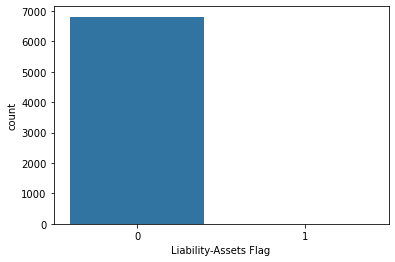

In [8]:
print(ds['Liability-Assets Flag'].value_counts())
sns.countplot('Liability-Assets Flag',data=ds)

Liability-Assets Flag  Bankrupt?
0                      0            6597
                       1             214
1                      1               6
                       0               2
dtype: int64


<AxesSubplot:xlabel='Liability-Assets Flag', ylabel='count'>

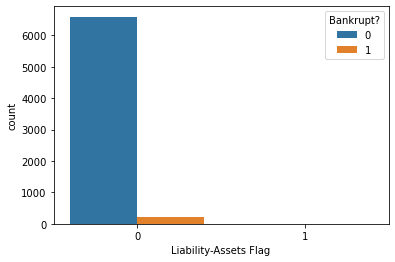

In [9]:
print(ds[['Liability-Assets Flag','Bankrupt?']].value_counts())
sns.countplot(x = 'Liability-Assets Flag',hue = 'Bankrupt?',data = ds)

The "Net Income" flag denotes the status of an organization's income in the last two years, where if the net income is negative for the past two years, the flagged value will be 1, else the value is 0. We observe that all the records have been exhibiting a loss for the past two years.

1    6819
Name: Net Income Flag, dtype: int64


<AxesSubplot:xlabel='Net Income Flag', ylabel='count'>

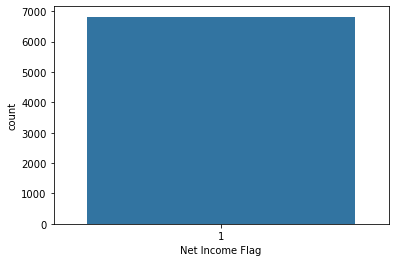

In [10]:
print(ds['Net Income Flag'].value_counts())
sns.countplot('Net Income Flag',data=ds,)

Net Income Flag  Bankrupt?
1                0            6599
                 1             220
dtype: int64


<AxesSubplot:xlabel='Net Income Flag', ylabel='count'>

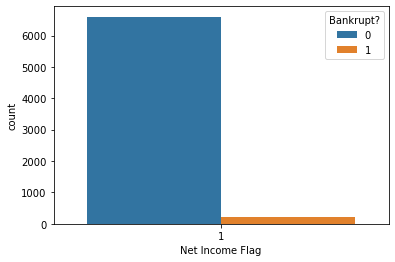

In [11]:
print(ds[['Net Income Flag','Bankrupt?']].value_counts())
sns.countplot(x = 'Net Income Flag',hue = 'Bankrupt?',data = ds)

Many organizations that have suffered losses for the past years but have stabilized their business, thus avoiding bankruptcy

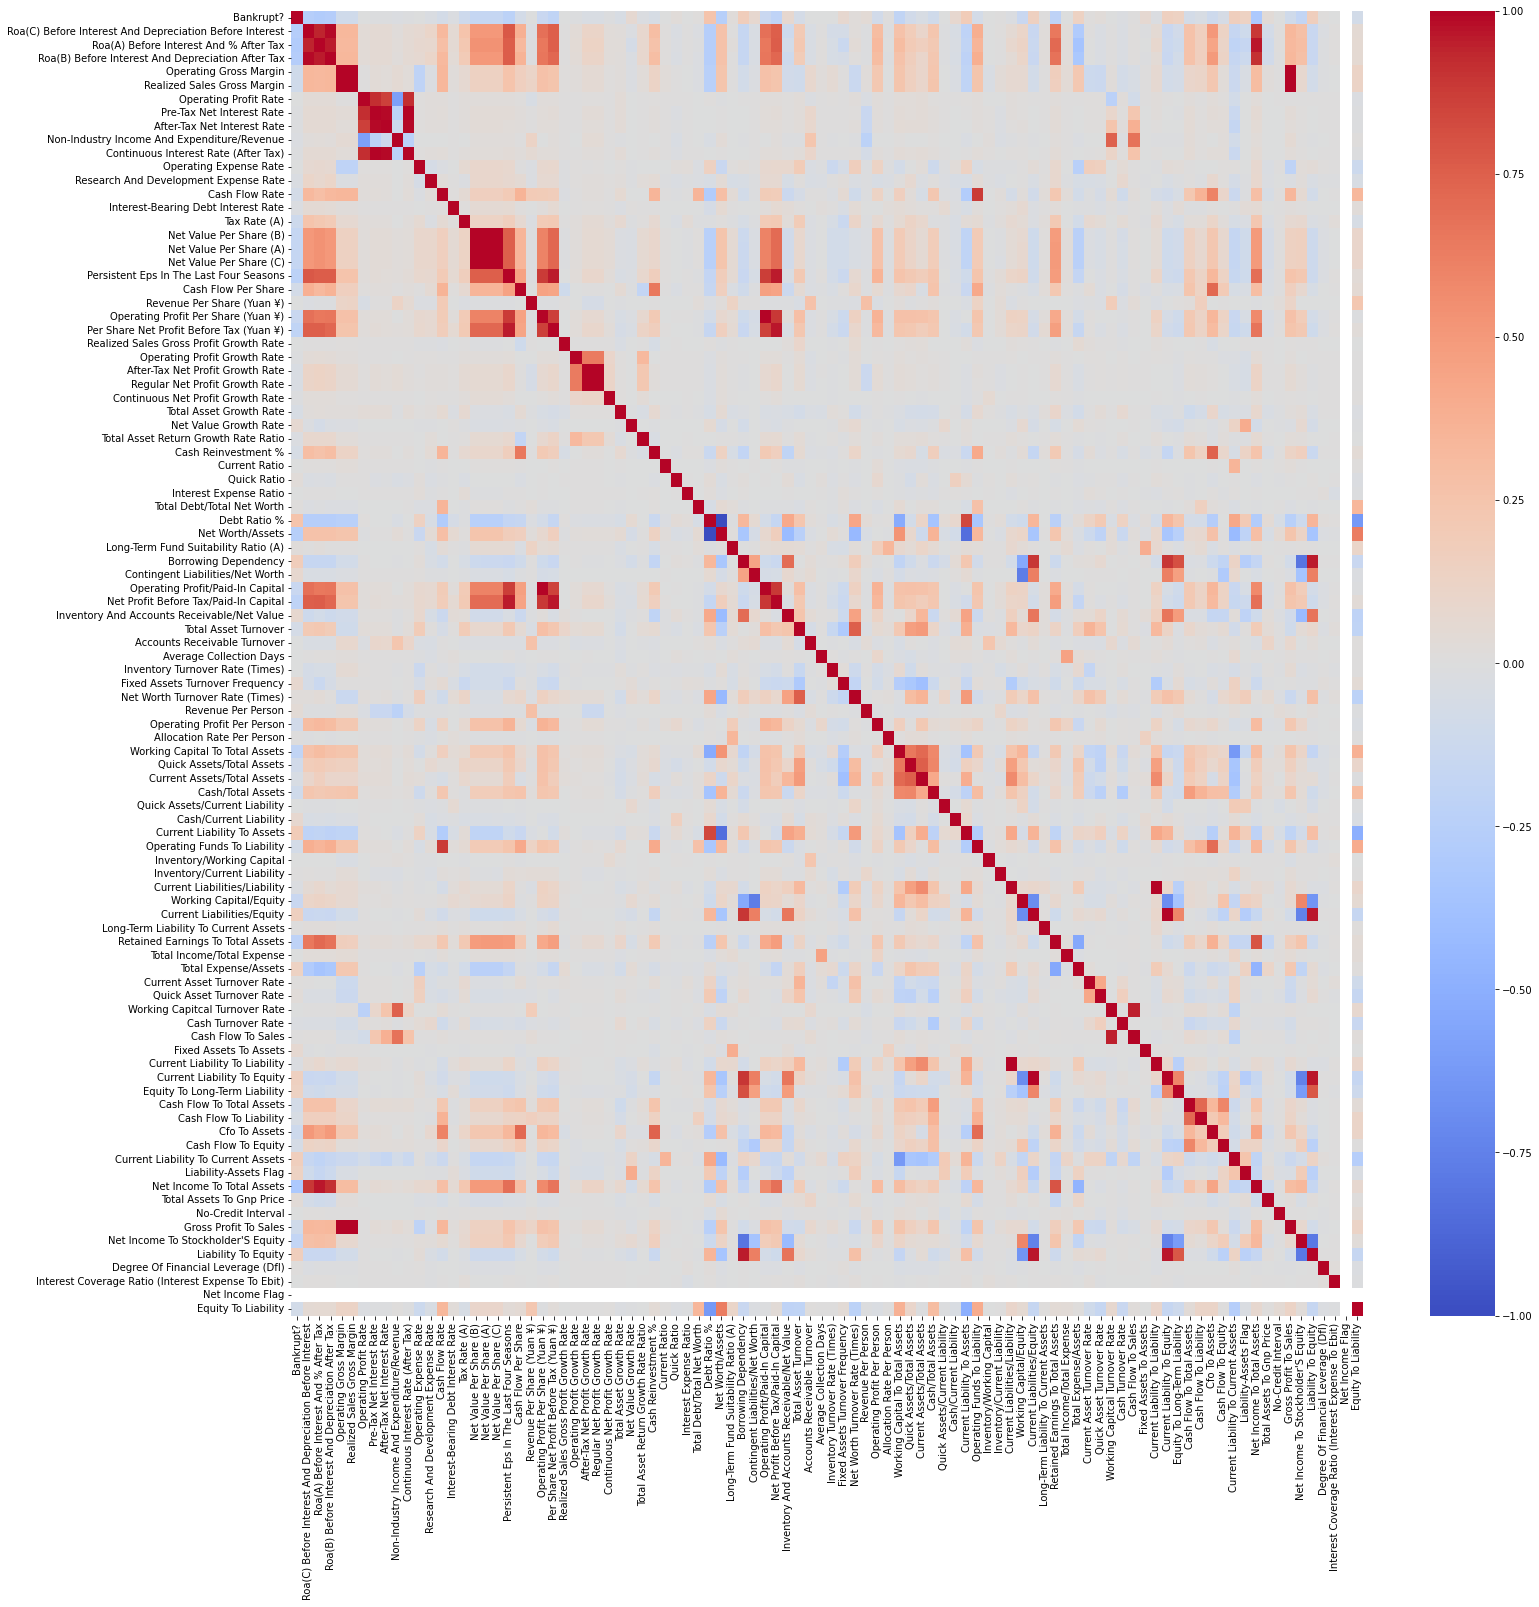

In [12]:
plt.figure(figsize=(24,24))
sns.heatmap(ds.corr(), annot=False, cmap='coolwarm')
plt.show()

In [13]:
positive_corr = ds[numeric_features].corrwith(ds["Bankrupt?"]).sort_values(ascending=False)[:6].index.tolist()
negative_corr = ds[numeric_features].corrwith(ds["Bankrupt?"]).sort_values()[:6].index.tolist()

positive_corr = ds[positive_corr + ["Bankrupt?"]].copy()
negative_corr = ds[negative_corr + ["Bankrupt?"]].copy()

### For the sake of simplicity, we analyze the six top positively and negatively correlated attributes.

In [14]:
def corrbargraph(x_value, y_value):
    
    plt.figure(figsize=(15,8))

    for i in range(1,7):
        plt.subplot(2,3,i)  
        sns.barplot(x = x_value, y = y_value[i-1],data = ds, palette='coolwarm')

    plt.tight_layout(pad=0.5)

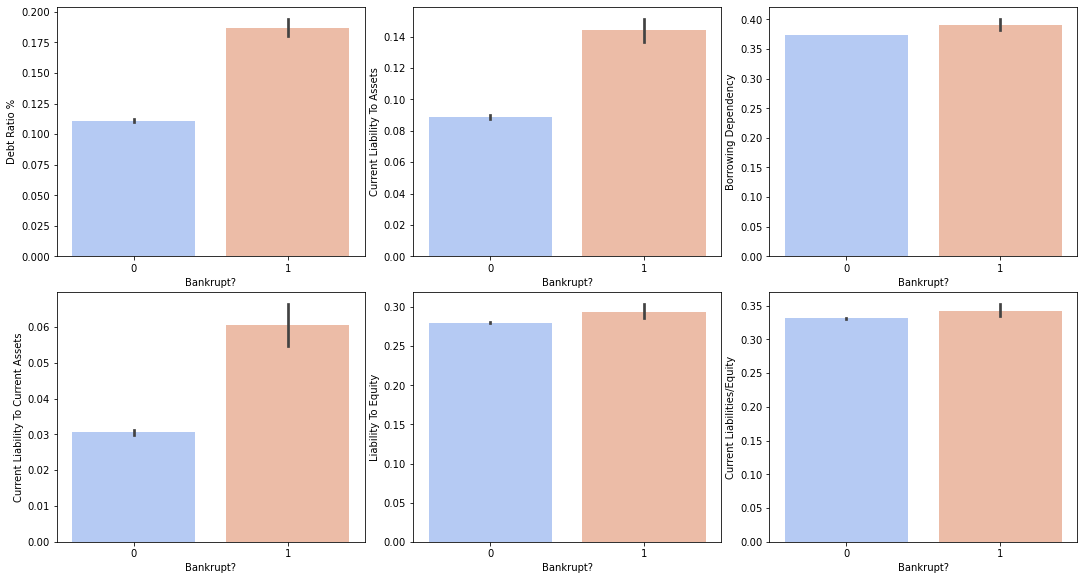

In [15]:
x_value = positive_corr.columns.tolist()[-1]
y_value = positive_corr.columns.tolist()[:-1]

corrbargraph(x_value, y_value)

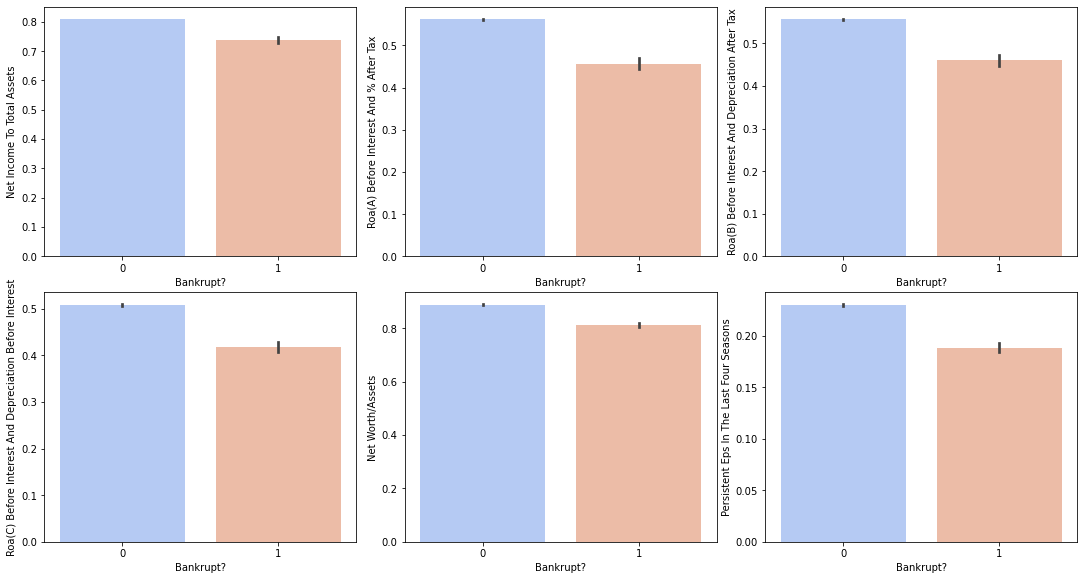

In [16]:
x_value = negative_corr.columns.tolist()[-1]
y_value = negative_corr.columns.tolist()[:-1]

corrbargraph(x_value, y_value)

These attributes show us that the more the assets and earing of a company, the less likely is the organization to be bankrupt.

Let us check the relation of top six positive and negative correlation attributes among eachother


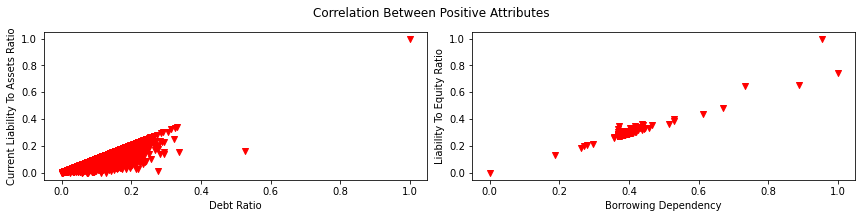

In [17]:
plt.figure(figsize=(12,3))

plt.suptitle("Correlation Between Positive Attributes")

plt.subplot(1,2,1)
plt.xlabel("Debt Ratio")
plt.ylabel("Current Liability To Assets Ratio")
plt.scatter(ds["Debt Ratio %"],ds["Current Liability To Assets"], marker='v',color = 'red')

plt.subplot(1,2,2)
plt.xlabel("Borrowing Dependency")
plt.ylabel("Liability To Equity Ratio")
plt.scatter(ds["Borrowing Dependency"],ds["Liability To Equity"], marker='v',color = 'red')

plt.tight_layout(pad=0.8)

There is a positive relation between attributes that have a high correlation with the target attribute.

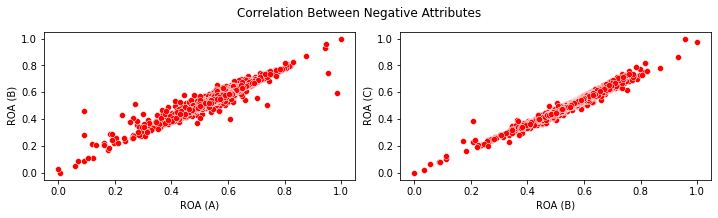

In [18]:
plt.figure(figsize=(10,3))

plt.suptitle("Correlation Between Negative Attributes")

plt.subplot(1,2,1)
plt.xlabel("ROA (A)")
plt.ylabel("ROA (B)")
sns.scatterplot(data=ds, x='Roa(A) Before Interest And % After Tax', y='Roa(B) Before Interest And Depreciation After Tax',color = 'red')

plt.subplot(1,2,2)
plt.xlabel("ROA (B)")
plt.ylabel("ROA (C)")
sns.scatterplot(data=ds, x='Roa(B) Before Interest And Depreciation After Tax', y='Roa(C) Before Interest And Depreciation Before Interest',color = 'red')

plt.tight_layout(pad=0.8)

There is a positive relation between attributes that have a low correlation with the target attribute

<AxesSubplot:>

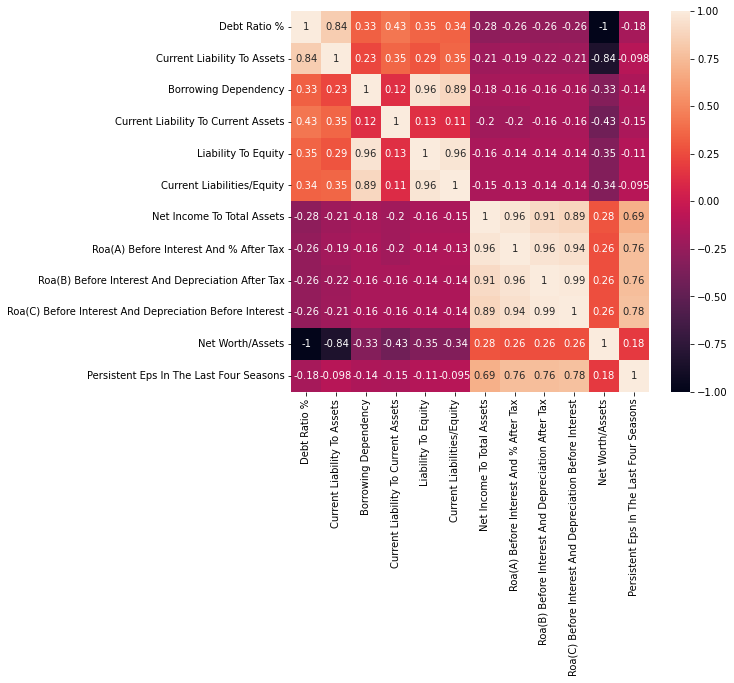

In [19]:
relation = positive_corr.columns.tolist()[:-1] + negative_corr.columns.tolist()[:-1]
plt.figure(figsize=(8,7))
sns.heatmap(ds[relation].corr(),annot=True)

A total correlation of the top 12 attributes are given above

____

## Data Sampling

## Balancing the dataset using SMOTE

In [20]:
X = ds.drop('Bankrupt?', axis=1)
y = ds['Bankrupt?']

In [21]:
oversample = SMOTE()
X , y = oversample.fit_resample(X,y)

<AxesSubplot:xlabel='Bankrupt?', ylabel='count'>

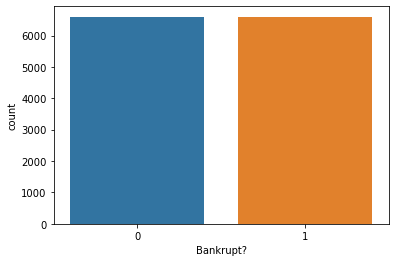

In [22]:
sns.countplot(x=y)

### Train Test Split

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

### Feature Selection using Mutual Interest

Text(0, 0.5, 'Mutual Information')

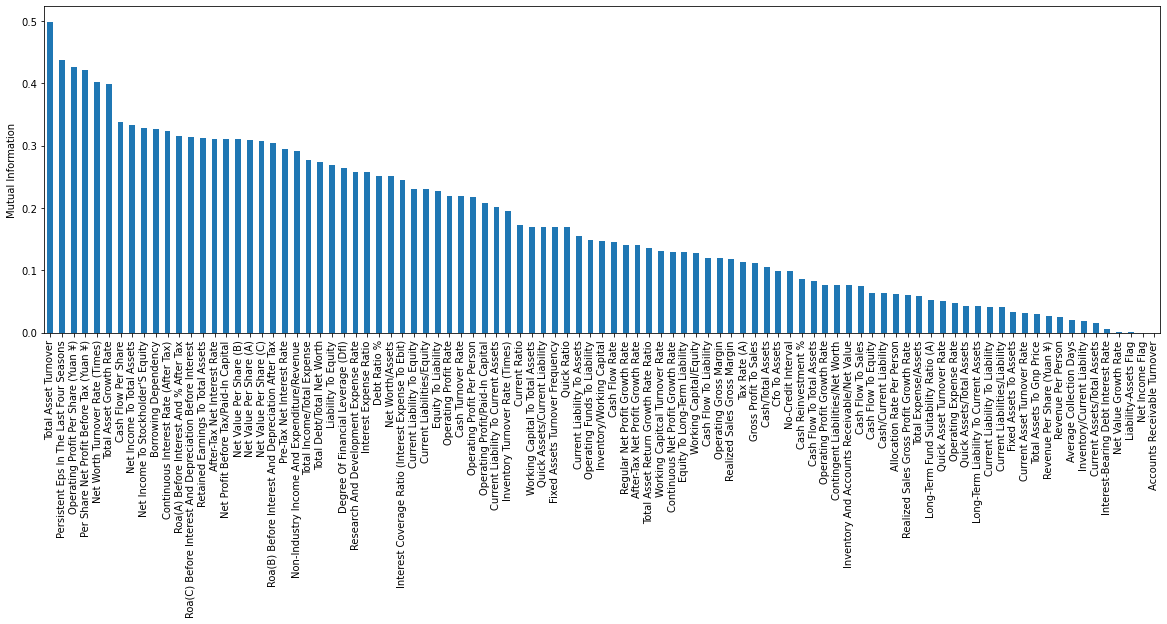

In [24]:
# #* calculate the mutual information between the variables and the target
# the smaller the value of the mi, the less information we can infer 
# from the feature about the target

mi = mutual_info_classif(X_train, y_train)
# mi

#* Display var plot of mi
# #? 1) let's capture the above array in a pandas series
# #? 2)add the variable names in the index
# #? 3) sort the features based on their mutual information value
# #? 4) and make a var plot

mi = pd.Series(mi)
mi.index = X.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [25]:
feature_sel = SelectKBest(mutual_info_classif, k=22).fit(X_train, y_train)
# feature_sel = SelectKBest(f_classif, k=10).fit(X_train, y_train)


In [35]:
selected_features = X.columns[feature_sel.get_support()]
# display selected features
selected_features
# len(selected_features)

Index(['Roa(C) Before Interest And Depreciation Before Interest',
       'Roa(A) Before Interest And % After Tax',
       'Roa(B) Before Interest And Depreciation After Tax',
       'Pre-Tax Net Interest Rate', 'After-Tax Net Interest Rate',
       'Non-Industry Income And Expenditure/Revenue',
       'Continuous Interest Rate (After Tax)', 'Net Value Per Share (B)',
       'Net Value Per Share (A)', 'Net Value Per Share (C)',
       'Persistent Eps In The Last Four Seasons', 'Cash Flow Per Share',
       'Operating Profit Per Share (Yuan ¥)',
       'Per Share Net Profit Before Tax (Yuan ¥)', 'Total Asset Growth Rate',
       'Borrowing Dependency', 'Net Profit Before Tax/Paid-In Capital',
       'Total Asset Turnover', 'Net Worth Turnover Rate (Times)',
       'Retained Earnings To Total Assets', 'Net Income To Total Assets',
       'Net Income To Stockholder'S Equity'],
      dtype='object')

In [27]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Model Building

## Logistic Regression

In [28]:
classifier_lr = LogisticRegression(random_state = 0)
classifier_lr.fit(X_train, y_train)

y_pred = classifier_lr.predict(X_test)
print(y_pred)

acc_lr = accuracy_score(y_test, y_pred)
print(f"Accuracy score Logistic Regression: {acc_lr}")

[0 1 0 ... 0 1 0]
Accuracy score Logistic Regression: 0.9109848484848485


## SVM

In [29]:
classifier_svc = SVC(kernel = 'linear', random_state = 0)
classifier_svc.fit(X_train, y_train)

y_pred = classifier_svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

acc2 = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {acc2}")

[[1154  150]
 [  77 1259]]
Accuracy score: 0.9140151515151516


## KNN

In [30]:
classifier_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier_knn.fit(X_train, y_train)

y_pred = classifier_knn.predict(X_test)



acc3 = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {acc3}")

Accuracy score: 0.9424242424242424


## Decesion Tree

In [31]:
classifier_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier_dt.fit(X_train, y_train)

y_pred = classifier_dt.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

acc5 = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {acc5}")

[[1230   74]
 [  41 1295]]
Accuracy score: 0.9564393939393939


## Random Forest

In [32]:
classifier_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_rf.fit(X_train, y_train)

y_pred = classifier_rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

acc6 = accuracy_score(y_test, y_pred)
print(f"Random Forest Classification accuracy: {acc6}")


[[1243   61]
 [  11 1325]]
Random Forest Classification accuracy: 0.9727272727272728


## XGBoost

In [33]:
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier()
classifier_xgb.fit(X_train, y_train)

y_pred = classifier_xgb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

acc7 = accuracy_score(y_test, y_pred)
print(f"By XG Boost classifier Acc: {acc7}")

[[1265   39]
 [   1 1335]]
By XG Boost classifier Acc: 0.9848484848484849
